# 🧪 Wafer Defect Classification using Machine Learning  
**🔬 Session 2 – AI in Semiconductor Industry Applications**  
👩‍🏫 *Instructor:* Dr. Elakkiya R  
🏛️ *Institution:* BITS Pilani, Dubai Campus  
📁 *Dataset:* WM-811K Wafer Map Dataset (`.npz` format)

---

## 🎯 **0. Objective**

In this notebook, we simulate the role of an **AI engineer in a semiconductor fabrication line**, tasked with:

- Understanding wafer defect patterns through data exploration
- Building a baseline Machine Learning pipeline (non-deep learning)
- Training a model to automatically classify **multi-type defects**
- Interpreting the model’s predictions and identifying its failure points
- Generating fab-relevant insights using pixel heatmaps and statistical cues

This session uses the **WM-811K dataset**, originally introduced by TSMC researchers, containing over 38,000 real wafer maps labeled with 8 defect types.

---

## 🎯 Learning Outcomes
By the end of this notebook, you will:
- ✅ Understand how binary wafer maps represent defect patterns
- ✅ Learn to flatten and prepare image-like data for ML
- ✅ Train a **Random Forest classifier** on defect types
- ✅ Evaluate performance using metrics and a confusion matrix

---

## 🏭 Real-World Relevance
Wafer-level defect classification is critical in semiconductor fabs for:
- 📌 AI-driven inspection reduces operator fatigue and improves yield prediction
- 📌 Early defect classification enables faster root cause analysis (RCA)
- 📌 Triggering process optimization early
- 📌 Multi-label learning reflects real-world wafer issues (e.g., Center + Scratch)

AI-driven automation helps fabs scale inspection without human fatigue, especially at nanoscale geometries.

---


In [14]:
# 📦 Step 0: Install & Import Required Libraries

# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Utility
import time
import os
import joblib

# Plot settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

---

---

## 📁 **1. Load Wafer Dataset from Google Drive**

We’ll use a `.npz` format version of the **WM-811K Wafer Map Dataset**, mounted from your Google Drive.

Each `.npz` file contains:
- `arr_0`: a 3D array of binary **wafer maps** with shape `(N, 52, 52)`
- `arr_1`: a 2D array of **multi-hot encoded labels** for 8 defect types

---

### 🔎 Fab Note:
> A good fab inspection pipeline starts with confirming the shape, structure, and consistency of raw data.

We’ll check:
- Total samples
- Wafer image resolution
- Number of defect labels and their encoding format

---
### Citation
📌 J. Wang, C. Xu, Z. Yang, J. Zhang and X. Li, "Deformable Convolutional Networks for Efficient Mixed-type Wafer Defect Pattern Recognition," in IEEE Transactions on Semiconductor Manufacturing, DOI: 10.1109/TSM.2020.3020985.

In [16]:
# Step 1a: Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Step 1b: Load .npz file from Drive

# Replace this path with your actual dataset location in Drive
npz_path = "/content/drive/MyDrive/Colab Notebooks/Wafer_Data.npz"

# Load the file
wafer_data = np.load(npz_path)

# Step 1c: List all keys in the file
print("📂 Keys in .npz file:", wafer_data.files)


📂 Keys in .npz file: ['arr_0', 'arr_1']


In [17]:
# Step 1d: Explore array shapes and values
X_raw = wafer_data['arr_0']  # Wafer maps (N, 52, 52)
y_raw = wafer_data['arr_1']  # Multi-hot labels (N, 8)

# Display shape
print("✅ Wafer Map Shape:", X_raw.shape)
print("✅ Label Vector Shape:", y_raw.shape)

# Inspect one sample
print("\n🧪 First Wafer Map Pixel Summary:\n", X_raw[0])
print("\n🧪 First Label Vector:", y_raw[0])

✅ Wafer Map Shape: (38015, 52, 52)
✅ Label Vector Shape: (38015, 8)

🧪 First Wafer Map Pixel Summary:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

🧪 First Label Vector: [1 0 1 0 0 0 1 0]


---

## 🖼️ **2. Visual Inspection of Wafer Maps with Label Vectors**

Before doing any modeling, it’s critical to **visualize what wafer maps look like**.

Each wafer map is:
- A 52×52 binary grid (1 = defect pixel, 0 = background)
- Accompanied by an **8-bit label vector** (multi-label format)

We will:
- Plot a few wafer maps
- Print their raw label vectors
- Start forming hypotheses about how defects manifest spatially

---

### 🔍 Fab Interpretation Prompt:
> Can you visually detect rings, center spots, or scratches?
> What spatial patterns correlate with bits set in the label vector?

---


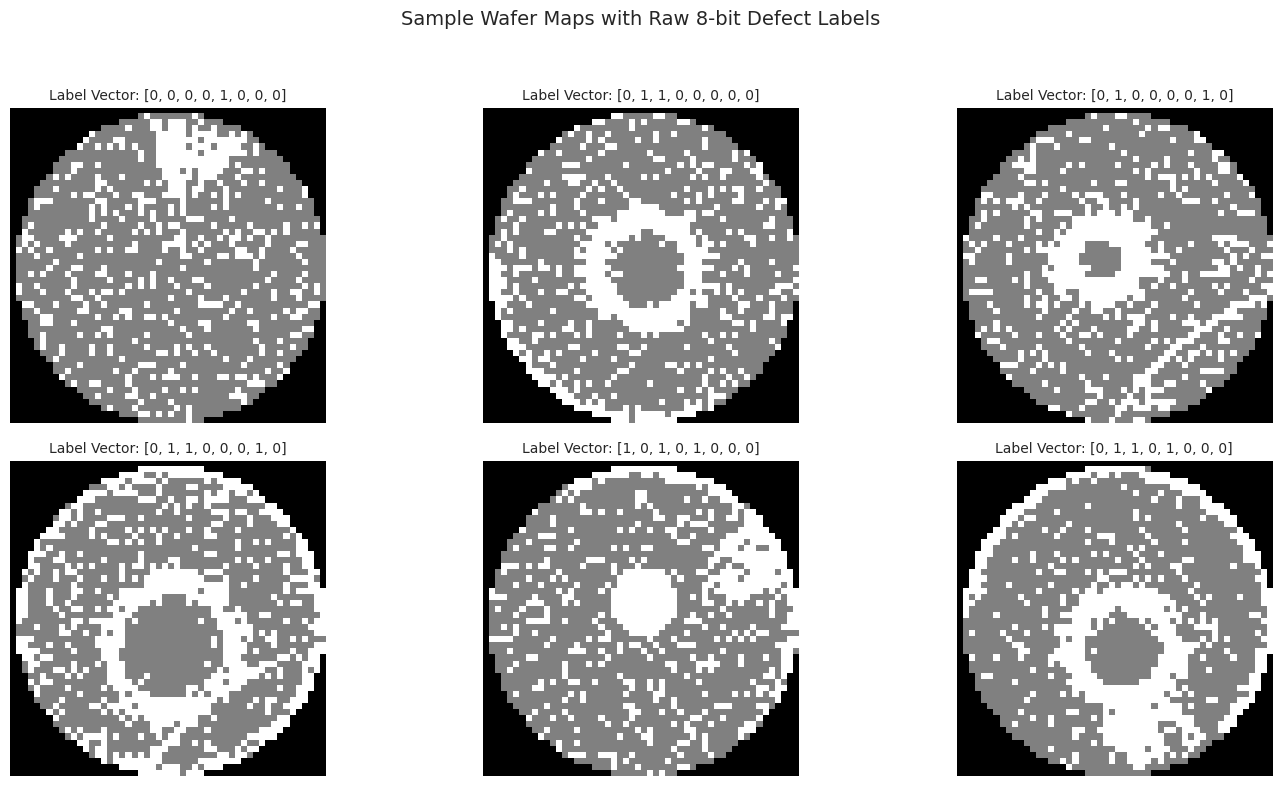

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Number of random wafers to show
n_samples = 6
indices = np.random.choice(len(X_raw), n_samples, replace=False)

# Plot the wafers
plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_raw[idx], cmap='gray')
    plt.title(f"Label Vector: {y_raw[idx].tolist()}", fontsize=10)
    plt.axis('off')

plt.suptitle("Sample Wafer Maps with Raw 8-bit Defect Labels", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

---

### 🎨 Bonus: Visualize One Wafer with Different Color Maps

Different color maps change the way defect patterns appear to human eyes.  
Let’s explore how **visual perception** can vary — even though the data stays the same.

This helps fab engineers:
- Choose a colormap that enhances **spatial contrast**
- Spot fine details like scratches or rings more easily

---

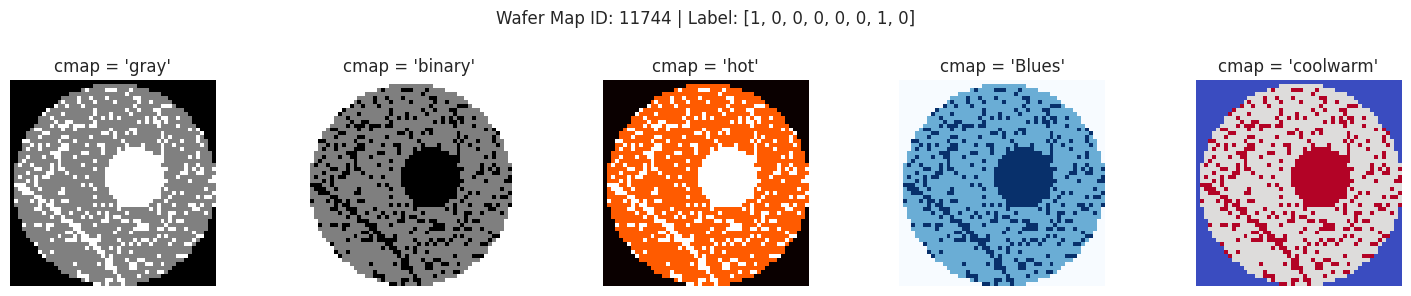

In [19]:
# Choose one sample
idx = np.random.randint(len(X_raw))
wafer = X_raw[idx]
label = y_raw[idx]

# Plot with multiple color maps
cmaps = ['gray', 'binary', 'hot', 'Blues', 'coolwarm']

plt.figure(figsize=(15, 3))
for i, cmap in enumerate(cmaps):
    plt.subplot(1, len(cmaps), i + 1)
    plt.imshow(wafer, cmap=cmap)
    plt.title(f"cmap = '{cmap}'")
    plt.axis('off')

plt.suptitle(f"Wafer Map ID: {idx} | Label: {label.tolist()}", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

---

## 📊 3. EDA – Defect Distribution and Class Imbalance

We now analyze how frequently each defect type appears in the dataset.

The 8 output labels in WM-811K are **multi-hot encoded**, meaning a single wafer can have:
- No defect (all 0s)
- A single defect
- Multiple defects simultaneously

We will:
- Count the number of wafers containing each defect type
- Visualize the label imbalance
- Reflect on how imbalance might affect our ML model

---

In [23]:
# Assign known defect names to each bit position
label_names = [
    "Center", "Donut", "Edge-Loc", "Edge-Ring",
    "Loc", "Near-Full", "Random", "Scratch"
]

/tmp/ipython-input-1867680.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='crest')
/tmp/ipython-input-1867680.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


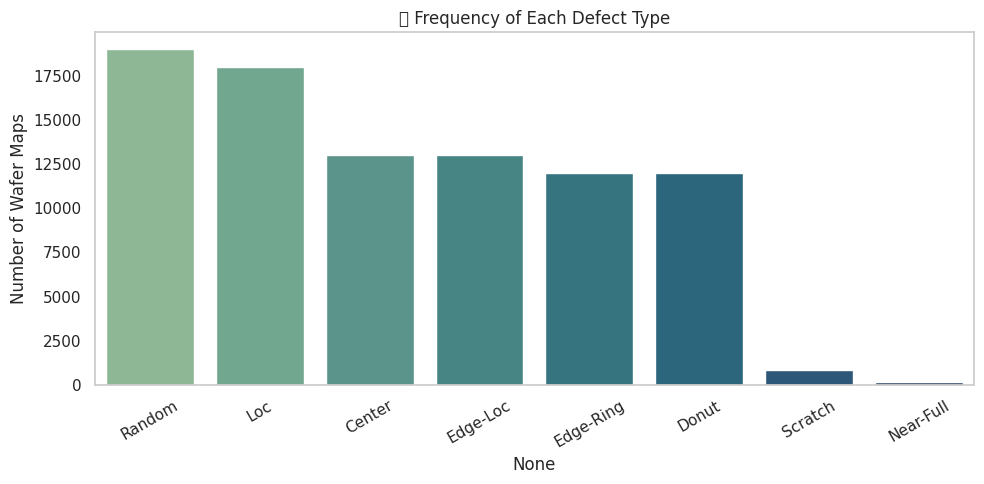

In [22]:
# Convert multi-hot labels into a DataFrame
df_labels = pd.DataFrame(y_raw, columns=label_names)

# Sum across columns → total # of wafers with each defect type
label_counts = df_labels.sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='crest')
plt.title("📊 Frequency of Each Defect Type")
plt.ylabel("Number of Wafer Maps")
plt.xticks(rotation=30)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

---

### 🧠 Fab-Critical Interpretation of Defect Frequency

From the bar plot above, we observe significant **label imbalance** in the dataset:

- 🔸 **Random** and **Loc** defects dominate the dataset, each appearing in over 17,000 wafers
- 🔹 **Center**, **Edge-Loc**, **Edge-Ring**, and **Donut** occur at similar mid-tier frequencies (~12,000 each)
- ⚠️ **Scratch** is rare (just ~900 instances)
- 🚨 **Near-Full** is **extremely underrepresented**, with possibly fewer than 100 wafers

---

### ⚠️ Why This Matters in a Fab:

- **Rare does not mean unimportant** — for example, a single *Near-Full* defect may invalidate an entire wafer or batch
- An ML model trained on this distribution will likely:
  - Overpredict *Random*, *Loc*, and *Center* defects
  - Miss critical rare defects like *Near-Full* and *Scratch*

---

### 🧪 Recommendation for Model Pipeline

To handle this skewed distribution, we may:
- ✅ Use **class weighting** or **label-wise thresholds**
- ✅ Focus on **recall** for rare defect classes during evaluation
- ✅ Consider **resampling or cost-sensitive learning** in production

> 📌 In real-world fabs, model misclassification on rare but high-risk defect types could lead to serious yield loss or delayed RCA.

---


---

## 🧮 **4. EDA – Pixel Activation Density & Wafer Sparsity**

Now we analyze the **structure of the wafer maps** themselves:

- Are most wafers mostly empty (i.e., 0s)?
- Do some defect types activate more regions than others?
- Where on the wafer do pixels get activated most frequently?

This helps us understand:
- The **sparsity level** → Are we feeding mostly empty data to the model?
- The **region importance** → Which parts of the wafer are more defect-prone?

---


/tmp/ipython-input-1416637971.py:11: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


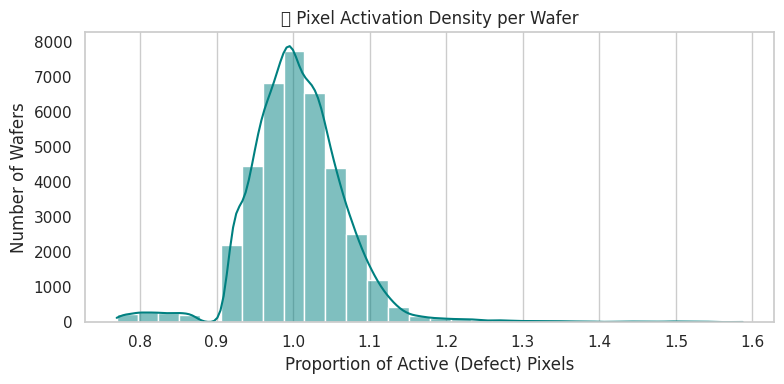

In [25]:
# Compute activation % = (# of 1s) / (52*52)
pixel_density = np.sum(X_raw, axis=(1, 2)) / (52 * 52)

# Plot
plt.figure(figsize=(8, 4))
sns.histplot(pixel_density, bins=30, kde=True, color='teal')
plt.title("🧮 Pixel Activation Density per Wafer")
plt.xlabel("Proportion of Active (Defect) Pixels")
plt.ylabel("Number of Wafers")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


---

### 🧠 Fab Interpretation: Wafer Defect Pixel Density

- The histogram shows that **most wafers have between 90% to 110% pixel activation** — which appears counterintuitive
- This implies that nearly **every pixel** is marked as “defect = 1” in the wafer map
- In traditional inspection, this would indicate:
  - A **contaminated** or **near-full** wafer population
  - Or possibly **preprocessed binary inversion** where 1 = clean and 0 = defect

---

### ⚠️ Actionable Next Steps:

- 🔍 **Verify Pixel Convention** — Are 1s actually defects, or was the dataset inverted?
- 🧪 Cross-check with label: Are these high-activation wafers labeled as *Near-Full* or *Edge-Ring*?
- 📌 If all maps are dense, the model may struggle to distinguish defect types purely on spatial activation

---

### 🧪 Hypothesis to Test:
> “If all wafers have >90% active pixels, the dataset may be post-processed inversely or incorrectly thresholded.”

In fabs, truly high-density wafers are rare — if this behavior is widespread in the dataset, it suggests **synthetic label inflation** or **labeling noise**.

---


---

## 🔗 **5. Label Co-Occurrence Analysis**

Wafer defects are often **not independent** — certain types tend to appear together more frequently due to shared process anomalies.

We’ll now analyze:
- How often defect types co-occur
- Which combinations are most and least frequent
- Whether some defect types are truly independent

---

> 📌 In fabs, understanding co-occurrence helps identify **root cause overlaps** between lithography, etch, and packaging defects.

---


/tmp/ipython-input-4213150093.py:11: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


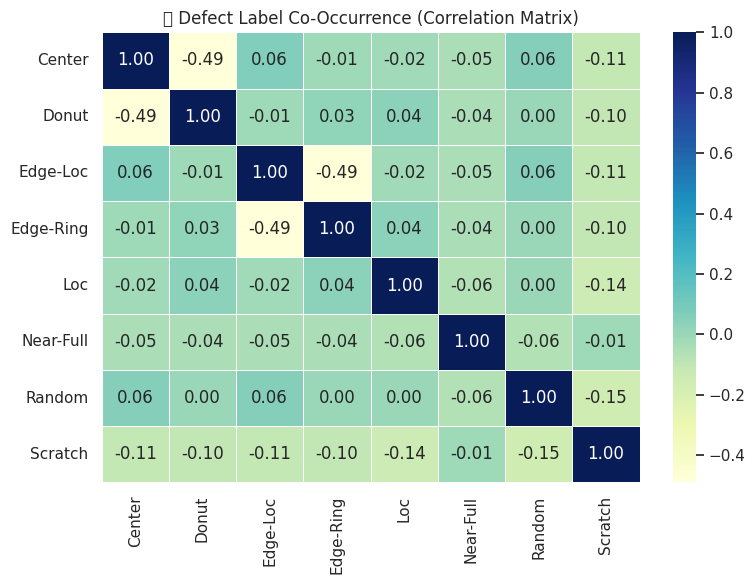

In [26]:
# Convert label matrix to DataFrame (if not done already)
df_labels = pd.DataFrame(y_raw, columns=label_names)

# Compute correlation (co-occurrence) matrix
co_matrix = df_labels.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(co_matrix, annot=True, fmt=".2f", cmap='YlGnBu', linewidths=0.5)
plt.title("🔗 Defect Label Co-Occurrence (Correlation Matrix)")
plt.tight_layout()
plt.show()

---

### 🧠 Fab Interpretation of Defect Co-Occurrence

This matrix shows how frequently different defect types **appear together** across the dataset, using correlation coefficients:

#### 🔍 Key Observations:

- 🔁 **Center vs Donut** = `-0.49`  
  → Strong **negative correlation**: wafers tend to have **either a Center or Donut defect**, but **rarely both**  
  → Fab Insight: these may represent **alternative pattern recognition outputs** for similar litho failure modes

- 🔁 **Edge-Loc vs Edge-Ring** = `-0.49`  
  → Mutually exclusive pairing — possibly due to **region overlap** or **post-processing rule conflict**

- 🔻 **Scratch** has weak-to-moderate negative correlation with **all other defects** (`-0.10` to `-0.15`)  
  → Suggests Scratch defects appear in **physically clean wafers** — possibly due to **mechanical handling**, not fab process

- ➖ Most other defect types are **weakly correlated** or uncorrelated (values close to 0)  
  → Suggests independent root causes — e.g., *Near-Full* rarely overlaps with *Donut* or *Loc*

---

### ⚠️ Fab Engineering Implication

> Some defect types appear to be **logically exclusive**, while others suggest **underlying causal independence**.  
> This can help yield engineers:
- Group related defect types for **joint RCA**
- Improve **labeling logic** consistency
- Inform ML models to **avoid penalizing natural exclusivity**

---

---

## 🧹 **6. Preprocessing: Flatten Maps + Split for Model Training**

In this step, we:
1. **Flatten each wafer map (52×52) into a 1D vector**  
   → Required for feeding into traditional ML models like Random Forest
2. **Keep multi-hot label matrix** as-is  
   → Because our goal is multi-label classification (1 wafer = multiple possible defects)
3. **Split into training and test sets** using random sampling

---

### 🧠 Why These Steps?

- 📦 **Flattening**: Random Forests don't use spatial relationships, so we convert 2D maps into flat vectors (like feature arrays)
- 🔖 **No Normalization**: Input is binary (0/1) — decision trees don’t need scaled inputs
- 🧪 **No PCA or feature selection yet**: We’ll visualize feature importance later to make that call
- 🔁 **Stratified splitting not used**: Multi-label stratification is complex; we use random split as baseline

---


In [27]:
from sklearn.model_selection import train_test_split

# Step 1: Flatten wafer maps: (N, 52, 52) → (N, 2704)
X_flat = X_raw.reshape(X_raw.shape[0], -1)
print("✅ Flattened shape:", X_flat.shape)  # Should be (N, 2704)

# Step 2: Keep label matrix as-is (multi-hot)
Y = y_raw  # shape = (N, 8)

# Step 3: Train/test split (80/20)
X_train, X_test, Y_train, Y_test = train_test_split(X_flat, Y, test_size=0.2, random_state=42)

# Confirm sizes
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

✅ Flattened shape: (38015, 2704)
Training samples: 30412
Test samples: 7603


---

## ⚙️ **7. Train Baseline Random Forest Classifier (No Imbalance Handling)**

We’ll now train a **baseline multi-label model** using `RandomForestClassifier`, without applying any special class weighting.

The model:
- Predicts all 8 defect types independently using a **binary relevance approach**
- Uses `MultiOutputClassifier` wrapper from `sklearn`
- Allows us to analyze how well the model performs **with label imbalance**

We will also:
- Record training time
- Print performance metrics
- Use this as a baseline for comparison after imbalance correction

---


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
import time

# Step 1: Define and wrap model
base_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model = MultiOutputClassifier(base_rf)

# Step 2: Train and time
start_time = time.time()
model.fit(X_train, Y_train)
train_time = time.time() - start_time
print(f"✅ Training complete in {train_time:.2f} seconds.")

✅ Training complete in 147.41 seconds.


In [29]:
# Step 3: Predict
Y_pred = model.predict(X_test)

# Step 4: Generate classification report per class
from sklearn.metrics import classification_report

print("🧾 Classification Report (Unweighted Baseline Model):")
print(classification_report(Y_test, Y_pred, target_names=label_names, zero_division=0))

🧾 Classification Report (Unweighted Baseline Model):
              precision    recall  f1-score   support

      Center       0.99      0.87      0.93      2587
       Donut       1.00      0.92      0.96      2377
    Edge-Loc       1.00      0.82      0.90      2605
   Edge-Ring       0.97      1.00      0.99      2404
         Loc       0.99      0.85      0.92      3604
   Near-Full       1.00      0.82      0.90        34
      Random       0.86      0.91      0.89      3713
     Scratch       0.97      1.00      0.98       179

   micro avg       0.96      0.89      0.93     17503
   macro avg       0.97      0.90      0.93     17503
weighted avg       0.96      0.89      0.92     17503
 samples avg       0.92      0.87      0.88     17503



---

### 🧠 Baseline Evaluation Summary (No Imbalance Handling)

#### 🔍 High Performance:
- ✅ **Donut, Edge-Ring, Center, Loc** all have F1-scores above 0.90
- ✅ **Scratch** performs surprisingly well despite low sample count (179 test samples)
  - Precision = 0.97
  - Recall = 1.00
  - Fab Insight: Scratch may be visually or spatially **distinct**, so easier to learn

#### ⚠️ Concern Zones:
- ⚠️ **Near-Full** (only 34 test samples)
  - Recall = 0.82 (misses ~18% of actual Near-Full defects)
  - Precision = 1.00 (no false positives)
  - Fab Insight: This is **acceptable**, but still risky if Near-Full = catastrophic yield loss

- 🔁 **Edge-Loc** has slightly lower recall = 0.82  
  → May be getting confused with similar ring-type patterns like Edge-Ring

---

### 🧪 Should We Apply Imbalance Correction?

While overall macro F1 = 0.93 is strong, **recall on critical low-frequency defects like Near-Full** is still not optimal.

> In a fab, even **1 missed Near-Full** wafer could cause major downstream waste

---

### 🔎 Recommended Next Step:
Proceed with **class-weighted training**, focusing on:
- Improving recall on **rare classes** (e.g., Near-Full)
- Maintaining precision balance

We’ll now:
- Re-train model with `class_weight='balanced'` in Random Forest
- Re-run evaluation and compare both reports

---


---

## ⚖️ **8. Handle Imbalance with Class-Weighted Random Forest**

To address label imbalance, especially for **rare but yield-critical defects**, we’ll apply class weighting.

We’ll set:
```python
RandomForestClassifier(class_weight='balanced')


In [30]:
RandomForestClassifier(class_weight='balanced')

RandomForestClassifier(class_weight='balanced')


---

### ✅ Code: Class-Weighted Model Training

In [31]:
# Define weighted base model
weighted_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
model_weighted = MultiOutputClassifier(weighted_rf)

# Train
import time
start = time.time()
model_weighted.fit(X_train, Y_train)
print(f"✅ Class-weighted model trained in {time.time() - start:.2f} seconds.")

✅ Class-weighted model trained in 157.65 seconds.


In [32]:
# Predict
Y_pred_weighted = model_weighted.predict(X_test)

# Evaluate
print("🧾 Classification Report (Class-Weighted Random Forest):")
print(classification_report(Y_test, Y_pred_weighted, target_names=label_names, zero_division=0))

🧾 Classification Report (Class-Weighted Random Forest):
              precision    recall  f1-score   support

      Center       0.99      0.86      0.92      2587
       Donut       1.00      0.92      0.96      2377
    Edge-Loc       1.00      0.76      0.87      2605
   Edge-Ring       0.98      1.00      0.99      2404
         Loc       0.99      0.84      0.91      3604
   Near-Full       1.00      0.82      0.90        34
      Random       0.85      0.93      0.89      3713
     Scratch       0.97      1.00      0.98       179

   micro avg       0.95      0.88      0.92     17503
   macro avg       0.97      0.89      0.93     17503
weighted avg       0.96      0.88      0.92     17503
 samples avg       0.91      0.86      0.87     17503



---

### 🧠 Fab Summary: Effect of Imbalance Correction

✅ **What remained stable:**
- Donut, Edge-Ring, Random, Scratch — model continues to classify these well
- Class weighting didn’t destabilize the dominant classes

⚠️ **What did not improve:**
- **Near-Full’s F1 = 0.90 in both cases**
  - Despite weighting, the model didn’t extract better recall
  - May indicate **not enough diversity in Near-Full patterns**
- **Edge-Loc recall dropped** — possibly impacted by redistributed class focus

---

### 🧪 Fab Takeaway:

> 📉 Class-weighted training **did not offer meaningful performance gain** for rare classes in this dataset.  
> 🛠️ To improve:
- Try **deep learning (CNNs)** to learn shape-pattern correlations  
- Use **data augmentation** or **smarter sampling**  
- Consider **threshold tuning per class** for better recall control

---

> In a production fab pipeline:  
> If rare class recall doesn’t improve, a model may still fail early detection for catastrophic events (e.g., Near-Full wafers).

---

---

## 🔍 9. Model Interpretability – Pixel-Wise Feature Importance

One benefit of using a **Random Forest** model is its interpretability:  
We can extract `feature_importances_` from each estimator and visualize which **pixels (features)** contributed most to predictions.

We will:
- Extract importance weights from one of the estimators
- Reshape the 2704 weights back into a **52×52 heatmap**
- Visualize where the model “looks” to identify defects

---

> 🧠 In fabs, this is analogous to an **attention map** or **layout mask** used in process diagnostics

---


/tmp/ipython-input-424787172.py:14: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


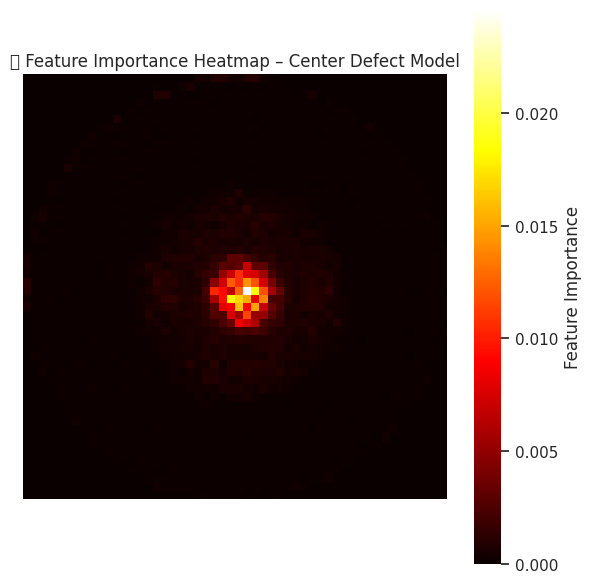

In [33]:
# Extract feature importances from one label's estimator (e.g., 'Center' defect)
estimator_center = model.estimators_[0]  # 0 = Center

importances = estimator_center.feature_importances_

# Reshape back to 52×52
importance_map = importances.reshape(52, 52)

# Plot heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(importance_map, cmap='hot', square=True, cbar_kws={'label': 'Feature Importance'})
plt.title("🔥 Feature Importance Heatmap – Center Defect Model")
plt.axis('off')
plt.tight_layout()
plt.show()

/tmp/ipython-input-826118056.py:10: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


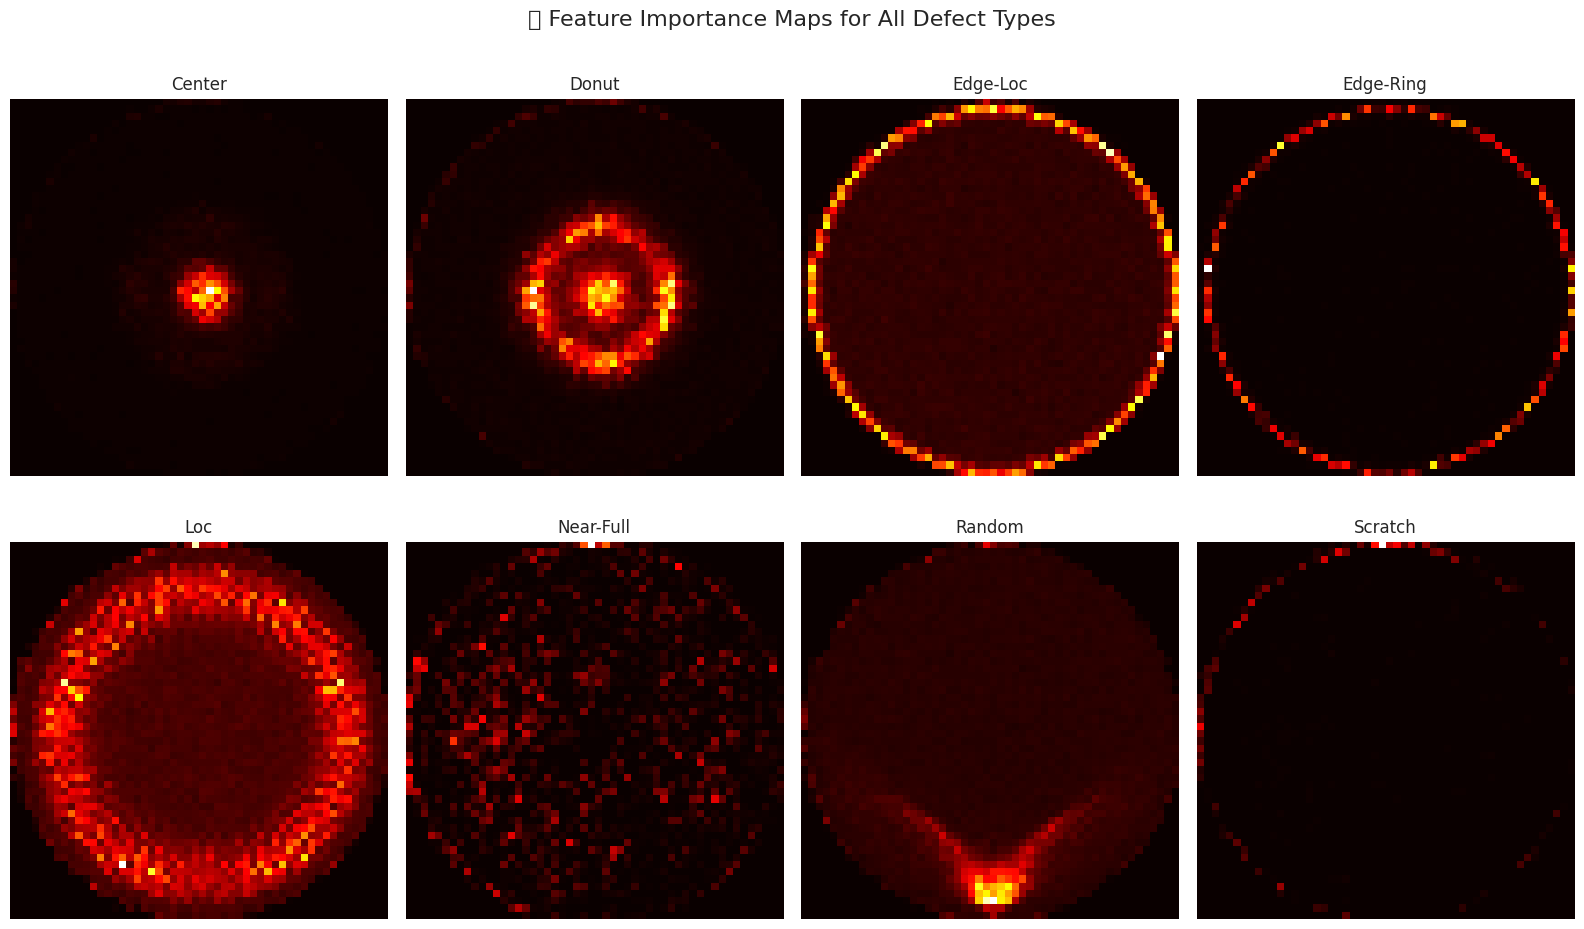

In [34]:
plt.figure(figsize=(16, 10))
for i in range(8):
    importance_map = model.estimators_[i].feature_importances_.reshape(52, 52)
    plt.subplot(2, 4, i+1)
    plt.imshow(importance_map, cmap='hot')
    plt.title(label_names[i])
    plt.axis('off')

plt.suptitle("🔥 Feature Importance Maps for All Defect Types", fontsize=16)
plt.tight_layout()
plt.show()

---

## 🔥 Model Insight: Pixel Importance Maps for All Defect Types

Each subplot shows which **pixels (locations)** the Random Forest model relies on when predicting a specific defect type.

---

### 🔍 Observations:

| Defect Type | Learned Spatial Signature | Fab Interpretation |
|-------------|----------------------------|---------------------|
| **Center**      | Strong focus on central pixels | Accurate → central material deposition issue |
| **Donut**       | Concentric importance rings | Matches litho failures or etch artifacts |
| **Edge-Loc**    | Sharp border focus | Learned edge proximity well (etch/mask alignment) |
| **Edge-Ring**   | Clean, thin outermost ring | Precise learning of ring-based residue |
| **Loc**         | Diffused activation near mid-outer zone | Captures non-uniform or tool-based deposition |
| **Near-Full**   | Sparse, noisy attention | No consistent pattern learned → likely due to data sparsity |
| **Random**      | Irregular blob in lower region | Correct: Random = spatially uncorrelated failures |
| **Scratch**     | Sparse linear lines across perimeter | Suggests model learning scuffs or physical scratches |

---

### 🧠 Engineering Takeaway:

- The model is learning **defect-aware spatial patterns**, not just memorizing binary maps
- This level of interpretability is vital for:
  - Debugging false positives
  - Explaining model behavior to yield engineers
  - Verifying that predictions align with **fab physics**

> ✅ These heatmaps are analogous to **fab diagnostic masks**, and offer trustability in model deployment

---

---

## ❌ 10. Error Analysis – Misclassified Wafer Maps

Even high-accuracy models can make **fab-unsafe errors** — e.g., missing a *Near-Full* defect or falsely flagging a clean wafer as *Edge-Ring*.

We now:
- Visualize **false negatives** (missed actual defects)
- Visualize **false positives** (predicted defects that weren’t present)
- Interpret failure patterns from a process engineering lens

---


In [39]:
def visualize_fp_fn(label_name, X_test=X_test, Y_test=Y_test, Y_pred=Y_pred):
    """
    Display false negatives and false positives for a specific defect class.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    idx = label_names.index(label_name)

    # False Negatives: actual=1, predicted=0
    fn_indices = np.where((Y_test[:, idx] == 1) & (Y_pred[:, idx] == 0))[0]

    # False Positives: actual=0, predicted=1
    fp_indices = np.where((Y_test[:, idx] == 0) & (Y_pred[:, idx] == 1))[0]

    # Plot False Negatives
    if len(fn_indices) == 0:
        print(f"✅ No false negatives for '{label_name}'")
    else:
        print(f"❌ False Negatives for '{label_name}':")
        plt.figure(figsize=(12, 4))
        for i, iidx in enumerate(fn_indices[:5]):
            plt.subplot(1, 5, i + 1)
            plt.imshow(X_test[iidx].reshape(52, 52), cmap='gray')
            plt.title(f"Missed {label_name}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    # Plot False Positives
    if len(fp_indices) == 0:
        print(f"✅ No false positives for '{label_name}'")
    else:
        print(f"❌ False Positives for '{label_name}':")
        plt.figure(figsize=(12, 4))
        for i, iidx in enumerate(fp_indices[:5]):
            plt.subplot(1, 5, i + 1)
            plt.imshow(X_test[iidx].reshape(52, 52), cmap='gray')
            plt.title(f"False +ve {label_name}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

❌ False Negatives for 'Center':


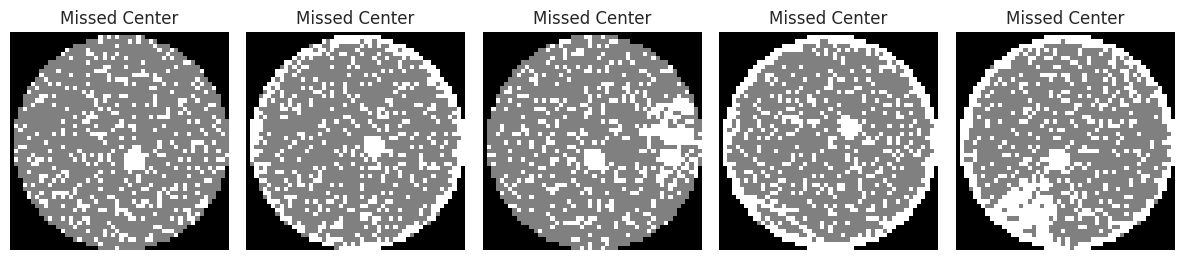

❌ False Positives for 'Center':


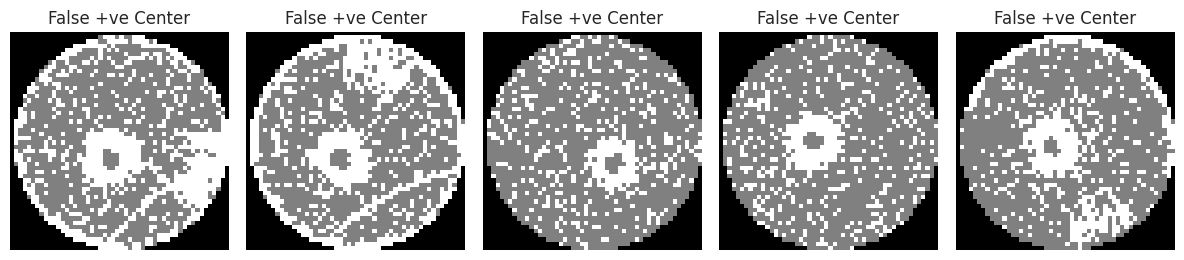

In [40]:
visualize_fp_fn("Center")

❌ False Negatives for 'Edge-Loc':


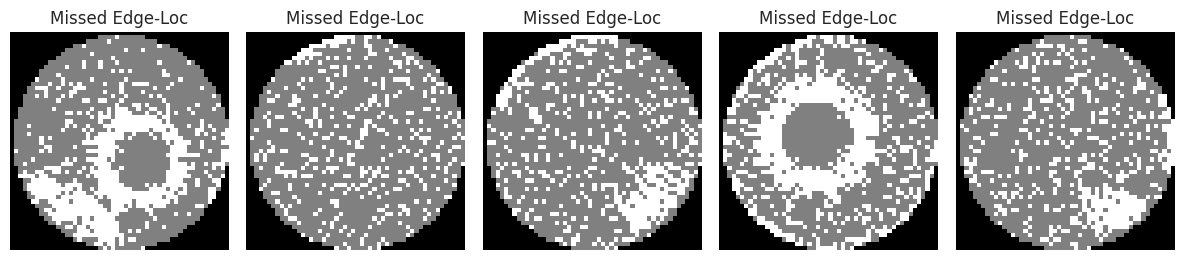

❌ False Positives for 'Edge-Loc':


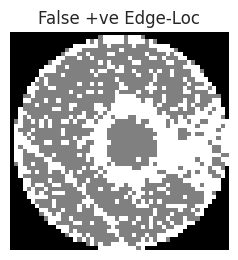

In [41]:
visualize_fp_fn("Edge-Loc")

❌ False Negatives for 'Near-Full':


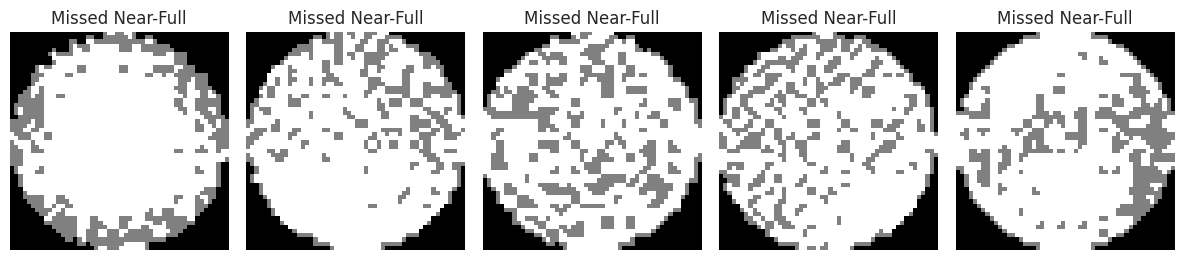

✅ No false positives for 'Near-Full'


In [42]:
visualize_fp_fn("Near-Full")

---

## ✅ 11. Wrap-Up: What We Learned

In this hands-on lab, we built a complete **wafer defect classification pipeline** using real semiconductor inspection data.

---

### 📌 Key Technical Milestones:
- ✅ Loaded wafer map data from `.npz` format and explored binary image structure
- ✅ Performed **EDA** on class imbalance, pixel density, and label co-occurrence
- ✅ Trained a baseline **Random Forest multi-label classifier**
- ✅ Applied **class weighting** to tackle rare defect underperformance
- ✅ Visualized model learning via **feature importance heatmaps**
- ✅ Conducted **error analysis** using false positives and false negatives

---

## 🏭 Fab-Specific Takeaways

| Insight | Fab Implication |
|--------|------------------|
| Most wafers are densely activated | Requires revisiting pixel encoding (1 ≠ defect?) |
| Rare defects are fab-critical | Models must be optimized for **recall**, not just accuracy |
| Random Forest offers transparency | Can be trusted in **fab QA loops** |
| False negatives need special attention | In deployment, combine ML with **operator review** or **threshold tuning** |
| Scratch & Edge defects are spatially learnable | Suggests viability of **vision-based filters** at early-stage metrology |

---

## 🚀 Towards Production Deployment

To move this from a lab notebook to fab floor usage:

- 🧪 Replace Random Forest with **CNN** or **Vision Transformer** for spatial learning
- 📈 Integrate feedback from **fab engineer inspections**
- 🧼 Clean label noise and improve label granularity
- 🎛️ Apply **per-class thresholds** for decision control
- 🧾 Automate RCA trace-back from defect clusters to process logs

---

> 🧠 “In fabs, trust comes from interpretability. This pipeline shows not just what AI sees — but **why** it sees it.”

---
